In [15]:
from utilities.utility import split_dataset, calc_rmsle, calc_new_preds, get_feature_importances, plot_observations_predictions, tune_rf_regressor, adjust_predictions

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

#### Training 255 Random Forest Regressors seperately
* Process that we'll be following is as follows.
* Select those 255 grains from train and test data.
* Use only the most important date related features.(We did feature engineering but only the date-related features seemed to be useful)
* We are creating this 255 regressors so that training, validation and hyper-parameter tuning happens for each grain individually, yielding better results.

In [3]:
train_data = pd.read_csv('../csv_files/train_data.csv')
val_data = pd.read_csv('../csv_files/val_data.csv')

In [35]:
units_count_df = train_data[train_data['units']!=0].groupby(['grain'])['units'].count().reset_index()

In [5]:
features = ['day','wday','year','month','week']
target = ['units']

In [6]:
rf_hyper_params = dict()
rf_hyper_params['n_estimators'] = [i for i in range(10,100,10)]
rf_hyper_params['max_depth'] = [3,5,10,20,30]
rf_hyper_params['n_jobs'] = [-1]

In [ ]:
trained_regressors_dict = dict()
trained_regressors_info = pd.DataFrame()

grain_index = 0
for grain in tqdm(units_count_df['grain'].values):
    temp_train_data = train_data[train_data['grain'] == grain][features + target]
    temp_val_data = val_data[val_data['grain'] == grain][features + target]
    temp_data = pd.concat([temp_train_data, temp_val_data])
    temp_train_x, temp_train_y, temp_val_x, temp_val_y = split_dataset(temp_data)
    ## We obtain a pre-trained random forest regressor from this for each grain
    best_hyper_params, min_rmsle, rf_regressor, predictions = tune_rf_regressor(rf_hyper_params, temp_train_x,
                                                                                temp_train_y, temp_val_x, temp_val_y)
    new_predictions, adj_diff_param, adj_min_rmsle = adjust_predictions(grain, predictions, temp_val_y)
    trained_regressors_dict[grain] = rf_regressor
    trained_regressors_info.loc[grain_index, 'grain'] = grain
    trained_regressors_info.loc[grain_index, 'best_hyper_params'] = str(best_hyper_params)
    trained_regressors_info.loc[grain_index, 'min_rmsle'] = min_rmsle
    trained_regressors_info.loc[grain_index, 'predictions'] = str(predictions)
    trained_regressors_info.loc[grain_index, 'adj_predictions'] = str(new_predictions)
    trained_regressors_info.loc[grain_index, 'adj_diff_param'] = adj_diff_param
    trained_regressors_info.loc[grain_index, 'adj_min_rmsle'] = adj_min_rmsle
    
    grain_index += 1

In [26]:
len(trained_regressors_dict.keys())

254

In [36]:
units_count_df

,grain,units
0,10_21,413
1,10_37,798
2,10_5,797
3,10_86,69
4,10_93,206
...,...,...
249,9_105,49
250,9_42,487
251,9_45,851
252,9_5,849


In [40]:
train_data[train_data['grain'] == '9_5']['units']

1537428    131
1537429     67
1537430    158
1537431     69
1537432    133
          ... 
1538275     44
1538276     39
1538277     27
1538278     17
1538279     56
Name: units, Length: 852, dtype: int64

In [8]:
val_x = val_data[val_data['grain'] == '15_45'][features]
val_y = val_data[val_data['grain'] == '15_45'][target]

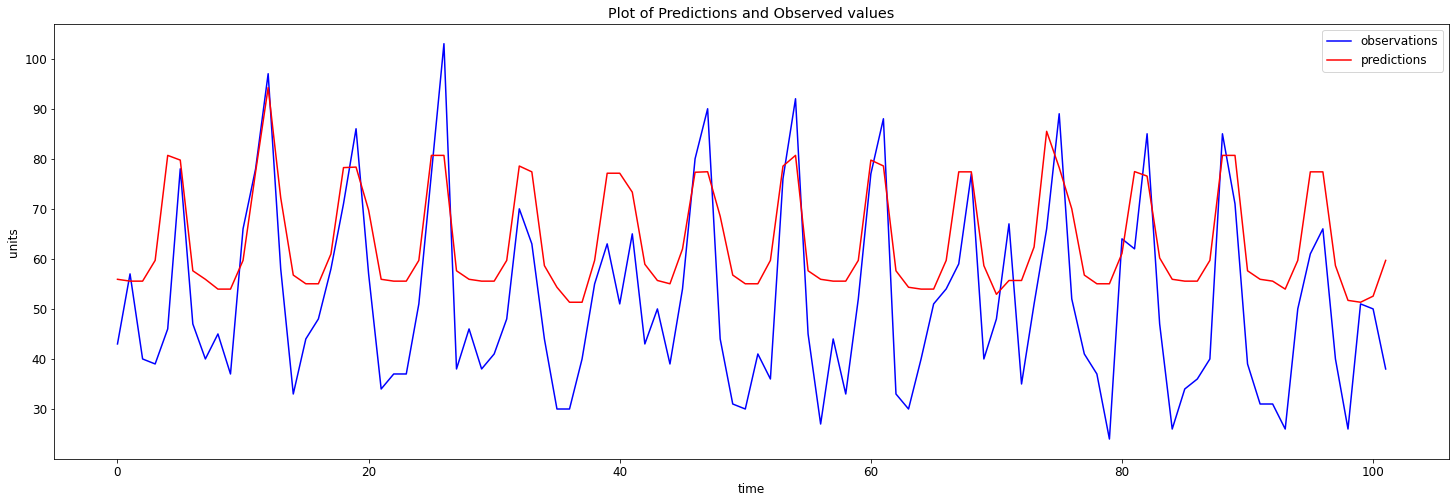

In [9]:
predictions = trained_regressors_dict['15_45'].predict(val_x)
plot_observations_predictions(val_y.values,predictions)

In [16]:
best_diff = trained_regressors_info[trained_regressors_info['grain'] == '15_45']['adj_diff_param'].values[0]
new_preds = calc_new_preds(predictions, best_diff)
plot_observations_predictions(val_y.values,new_preds)

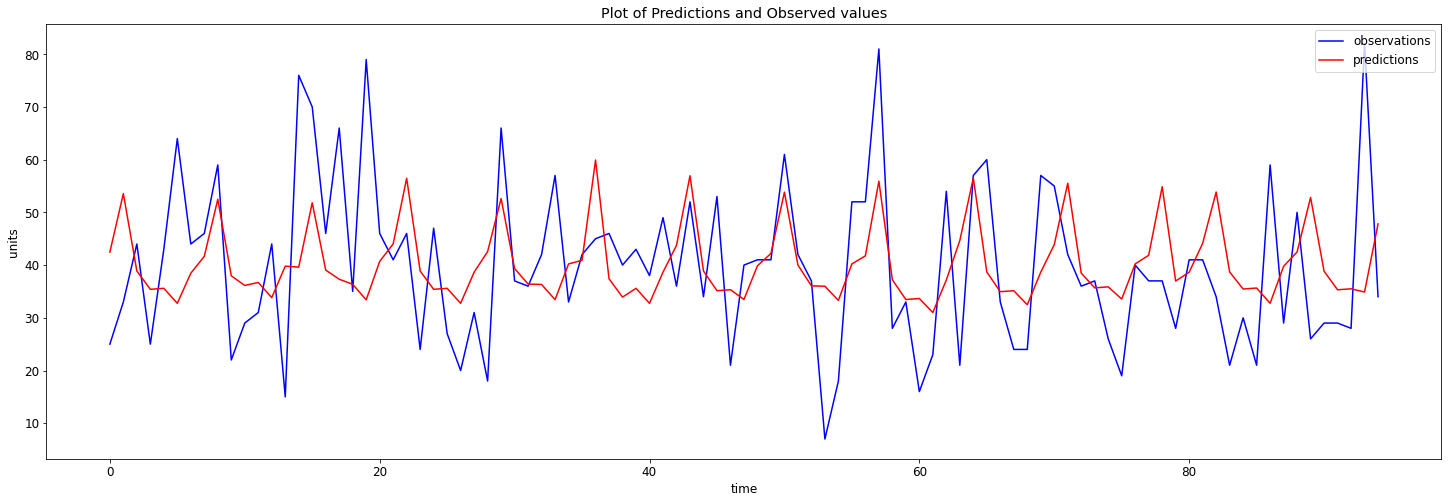

In [41]:
val_x = val_data[val_data['grain'] == '9_5'][features]
val_y = val_data[val_data['grain'] == '9_5'][target]
predictions = trained_regressors_dict['9_5'].predict(val_x)
plot_observations_predictions(val_y.values,predictions)

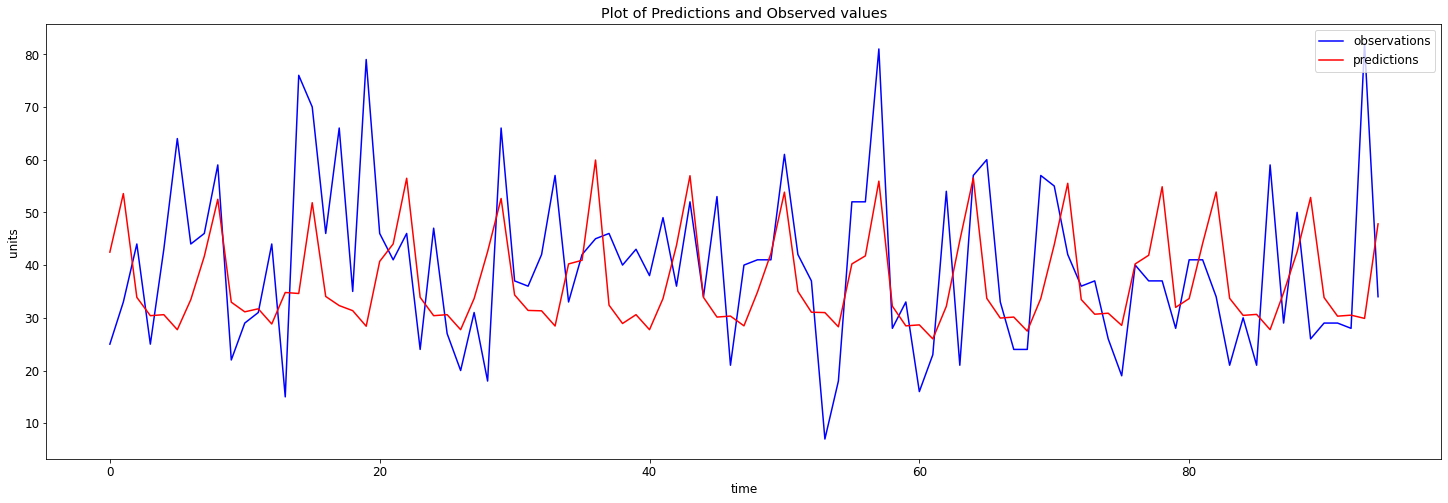

In [42]:
best_diff = trained_regressors_info[trained_regressors_info['grain'] == '9_5']['adj_diff_param'].values[0]
new_preds = calc_new_preds(predictions, best_diff)
plot_observations_predictions(val_y.values,new_preds)

In [18]:
import pickle

In [19]:
file = open('trained_regressors_dict','wb')
pickle.dump(trained_regressors_dict, file)
file.close()

In [20]:
trained_regressors_info.to_csv('trained_regressors_info',index=False)